In [16]:
# Step 1: Import pandas
import pandas as pd

# Step 2: Load the dataset (no header)
df = pd.read_csv("data/company_esg_financial_dataset.csv", header=None)

# Step 3: Check the first row to see if it's a header or real data
print(" First row of raw data:")
print(df.iloc[0].tolist())

# Step 4: Assign proper column names
columns = [
    "company_id", "company_name", "industry", "region", "year",
    "revenue", "profit_margin", "market_cap", "growth_rate",
    "esg_overall", "esg_environmental", "esg_social", "esg_governance",
    "carbon_emissions", "water_usage", "energy_consumption"
]

# Step 5: If the first row looks like real data (e.g., "Company_1", "Retail"...), keep it.
# But if it looks like ["CompanyID", "CompanyName", ...], then skip it.
first_row = df.iloc[0].astype(str).str.lower().tolist()
if "companyid" in first_row or "company_id" in first_row or "companyname" in first_row:
    # Drop the first row (it's a header)
    df = df.iloc[1:].copy()

# Now assign column names
df.columns = columns

# Step 6: Reset index and convert numeric columns
df = df.reset_index(drop=True)
numeric_cols = [
    "year", "revenue", "profit_margin", "market_cap", "growth_rate",
    "esg_overall", "esg_environmental", "esg_social", "esg_governance",
    "carbon_emissions", "water_usage", "energy_consumption"
]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Step 7: Show the first 5 clean rows
print("\n Cleaned data (first 5 rows):")
df.head()

 First row of raw data:
['CompanyID', 'CompanyName', 'Industry', 'Region', 'Year', 'Revenue', 'ProfitMargin', 'MarketCap', 'GrowthRate', 'ESG_Overall', 'ESG_Environmental', 'ESG_Social', 'ESG_Governance', 'CarbonEmissions', 'WaterUsage', 'EnergyConsumption']

 Cleaned data (first 5 rows):


,company_id,company_name,industry,region,year,revenue,profit_margin,market_cap,growth_rate,esg_overall,esg_environmental,esg_social,esg_governance,carbon_emissions,water_usage,energy_consumption
0,1,Company_1,Retail,Latin America,2015,459.2,6.0,337.5,NaN,57.0,60.7,33.5,76.8,35577.4,17788.7,71154.7
1,1,Company_1,Retail,Latin America,2016,473.8,4.6,366.6,3.2,56.7,58.9,32.8,78.5,37314.7,18657.4,74629.4
2,1,Company_1,Retail,Latin America,2017,564.9,5.2,313.4,19.2,56.5,57.6,34.0,77.8,45006.4,22503.2,90012.9
3,1,Company_1,Retail,Latin America,2018,558.4,4.3,283.0,-1.1,58.0,62.3,33.4,78.3,42650.1,21325.1,85300.2
4,1,Company_1,Retail,Latin America,2019,554.5,4.9,538.1,-0.7,56.6,63.7,30.0,76.1,41799.4,20899.7,83598.8


In [17]:
# Step 4: Check basic info about the dataset
print(" Dataset Info:")
df.info()

print("\n Summary Statistics:")
df.describe()

print("\n Unique Regions:")
print(df['region'].unique())

print("\n Unique Industries:")
print(df['industry'].unique())

 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   company_id          11000 non-null  object 
 1   company_name        11000 non-null  object 
 2   industry            11000 non-null  object 
 3   region              11000 non-null  object 
 4   year                11000 non-null  int64  
 5   revenue             11000 non-null  float64
 6   profit_margin       11000 non-null  float64
 7   market_cap          11000 non-null  float64
 8   growth_rate         10000 non-null  float64
 9   esg_overall         11000 non-null  float64
 10  esg_environmental   11000 non-null  float64
 11  esg_social          11000 non-null  float64
 12  esg_governance      11000 non-null  float64
 13  carbon_emissions    11000 non-null  float64
 14  water_usage         11000 non-null  float64
 15  energy_consumption  11000 non-null  fl

In [18]:
# Step 1: Calculate ESG trend (3-year change)
df['esg_trend'] = df.groupby('company_name')['esg_overall'].diff(periods=1)

# Step 2: Calculate industry average ESG (by year + industry)
df['industry_avg_esg'] = df.groupby(['industry', 'year'])['esg_overall'].transform('mean')

# Step 3: Calculate ESG gap (company vs industry)
df['esg_gap'] = df['esg_overall'] - df['industry_avg_esg']

# Step 4: Calculate profit margin trend (1-year change)
df['profit_trend'] = df.groupby('company_name')['profit_margin'].diff(periods=1)

# Step 5: Define Risk Score (higher = higher risk)
# We penalize: declining ESG, below-industry ESG, and falling profits
df['risk_score'] = (
    (0.4 * df['esg_gap'].clip(upper=0).abs()) +        # Only penalize if BELOW industry
    (0.3 * df['esg_trend'].clip(upper=0).abs()) +      # Only penalize if ESG is DECLINING
    (0.3 * df['profit_trend'].clip(upper=0).abs())     # Only penalize if profit is FALLING
)

# Step 6: Keep only the latest year (2025) for dashboard
latest_df = df[df['year'] == 2025].copy()

# Step 7: Show top 10 high-risk companies
print(" Top 10 High-Risk Companies (2025):")
print(latest_df[['company_name', 'industry', 'region', 'esg_overall', 'risk_score']]
      .sort_values('risk_score', ascending=False)
      .head(10))

 Top 10 High-Risk Companies (2025):
     company_name        industry         region  esg_overall  risk_score
3420  Company_311  Consumer Goods    Middle East         14.3   18.229655
923    Company_84  Consumer Goods    Middle East         18.1   16.499655
538    Company_49          Retail    Middle East         18.7   16.285660
3321  Company_302          Energy  Latin America         16.1   15.891852
4113  Company_374      Healthcare         Africa         23.8   15.595124
1209  Company_110      Healthcare    Middle East         26.6   14.175124
2166  Company_197          Energy  Latin America         19.1   14.061852
4784  Company_435          Retail    Middle East         24.9   13.895660
1550  Company_141          Energy         Africa         17.8   13.861852
2034  Company_185  Transportation  Latin America         16.5   13.844103


In [13]:
!pip install plotly


Defaulting to user installation because normal site-packages is not writeable


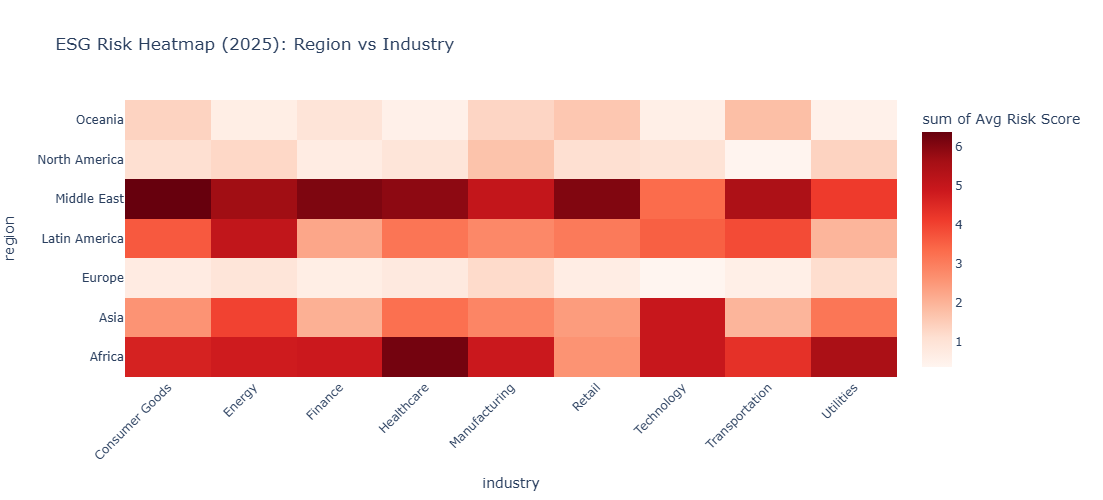

In [19]:
import plotly.express as px
import plotly.graph_objects as go

# Filter for 2025 and select key columns
dashboard_df = latest_df[['industry', 'region', 'risk_score']].copy()

# Calculate average risk score per (Region × Industry)
heatmap_data = dashboard_df.groupby(['region', 'industry'])['risk_score'].mean().reset_index()

# Create heatmap
fig = px.density_heatmap(
    heatmap_data,
    x='industry',
    y='region',
    z='risk_score',
    color_continuous_scale='Reds',
    title='ESG Risk Heatmap (2025): Region vs Industry',
    labels={'risk_score': 'Avg Risk Score'}
)

# Improve layout
fig.update_layout(
    width=800,
    height=500,
    xaxis_tickangle=-45
)

# Show the plot
fig.show()

In [22]:
# Step 1: Ensure data is sorted by company and year
df = df.sort_values(['company_name', 'year']).reset_index(drop=True)

# Step 2: Calculate ESG trend (1-year change)
df['esg_trend'] = df.groupby('company_name')['esg_overall'].diff()

# Step 3: Calculate industry average ESG (by year + industry)
df['industry_avg_esg'] = df.groupby(['industry', 'year'])['esg_overall'].transform('mean')

# Step 4: Calculate ESG gap (company vs industry)
df['esg_gap'] = df['esg_overall'] - df['industry_avg_esg']

# Step 5: Calculate financial stress proxy using AVAILABLE columns
df['profit_trend'] = df.groupby('company_name')['profit_margin'].diff()
df['market_cap_trend'] = df.groupby('company_name')['market_cap'].diff()

# Financial stress = profit margin falling AND market cap falling
financial_stress_flag = (
    (df['profit_trend'] < 0) & 
    (df['market_cap_trend'] < 0)
).astype(int) * 10  # Add 10 points if both are declining

# Step 6: Define Risk Score (higher = higher risk)
df['risk_score'] = (
    0.4 * df['esg_gap'].clip(upper=0).abs() +        # Penalize if BELOW industry ESG
    0.3 * df['esg_trend'].clip(upper=0).abs() +      # Penalize if ESG is DECLINING
    0.3 * financial_stress_flag                      # Penalize if financial stress detected
)

# Step 7: Focus on latest year (2025) for dashboard
latest_df = df[df['year'] == 2025].copy()

# Step 8: Show top 10 high-risk companies
print(" Top 10 High-Risk Companies (2025):")
print(latest_df[['company_name', 'industry', 'region', 'esg_overall', 'risk_score']]
      .sort_values('risk_score', ascending=False)
      .head(10))

 Top 10 High-Risk Companies (2025):
     company_name        industry         region  esg_overall  risk_score
2617  Company_311  Consumer Goods    Middle East         14.3   20.629655
9063   Company_84  Consumer Goods    Middle East         18.1   19.109655
3376  Company_374      Healthcare         Africa         23.8   17.875124
1209  Company_197          Energy  Latin America         19.1   16.341852
4784   Company_49          Retail    Middle East         18.7   16.285660
5928  Company_583      Healthcare         Africa         28.4   15.855124
9525  Company_878  Consumer Goods           Asia         26.6   15.709655
1308  Company_204          Retail    Middle East         27.6   15.605660
5356  Company_536  Transportation    Middle East         18.3   15.554103
5499  Company_548          Retail    Middle East         29.1   15.215660


In [23]:
# STEP A: Advanced ESG Risk Scoring Model (Accenture Japan Edition)

# Ensure data is sorted
df = df.sort_values(['company_name', 'year']).reset_index(drop=True)

# A1: ESG trend and profit trend
df['esg_trend'] = df.groupby('company_name')['esg_overall'].diff()
df['profit_trend'] = df.groupby('company_name')['profit_margin'].diff()

# A2: ESG volatility (3-year rolling std)
df['esg_volatility'] = df.groupby('company_name')['esg_overall'].transform(
    lambda x: x.rolling(window=3, min_periods=2).std()
)

# A3: Industry percentile rank
df['esg_percentile'] = df.groupby(['industry', 'year'])['esg_overall'].rank(pct=True)

# A4: Profit-ESG divergence (greenwashing signal)
df['profit_esg_divergence'] = (
    (df['esg_trend'] < 0) & (df['profit_trend'] > 0)
).astype(int)

# A5: Market cap volatility
df['market_cap_volatility'] = df.groupby('company_name')['market_cap'].transform(
    lambda x: x.rolling(3, min_periods=2).std() / x.rolling(3, min_periods=2).mean()
)

# A6: Financial stress flag
df['financial_stress'] = (
    (df['profit_trend'] < 0) & (df['market_cap_volatility'].fillna(0) > 0.1)
).astype(int)

# A7: Final risk score (0-100)
df['risk_score'] = (
    0.25 * (1 - df['esg_percentile']) * 100 +
    0.20 * df['esg_volatility'].fillna(0) * 10 +
    0.20 * df['profit_esg_divergence'] * 15 +
    0.20 * df['financial_stress'] * 20 +
    0.15 * (df['governance_score'] < df['governance_score'].quantile(0.3)).astype(int) * 10
)

# Focus on 2025
latest_df = df[df['year'] == 2025].copy()

# Show top 10 high-risk companies
print("⚠ Top 10 High-Risk Companies (2025):")
print(latest_df[['company_name', 'industry', 'region', 'esg_overall', 'risk_score', 'governance_score']]
      .sort_values('risk_score', ascending=False)
      .head(10))

KeyError: 'governance_score'